In [7]:
import matplotlib.pyplot  as plt
import pandas as pd
import numpy as np
import os

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

In [8]:
df_general = pd.read_excel("../data/BDD_DUODOPAEI.xlsx", sheet_name="general")
df_therapy = pd.read_excel("../data/BDD_DUODOPAEI.xlsx", sheet_name="therapy")
df_aes = pd.read_excel("../data/BDD_DUODOPAEI.xlsx", sheet_name="aes")

In [9]:
# Group by 'dropout_cause' and count
dropout_counts = df_general['dropout_cause'].value_counts(dropna=False)

# Create a new Series with formatted "n (%)"
dropout_summary = dropout_counts.apply(lambda n: f"{n} ({(n/df_general.patient_id.nunique()):.2f})")

# Convert to DataFrame for display
dropout_summary_df = dropout_summary.reset_index()
dropout_summary_df.columns = ['dropout_cause', 'n (%)']

print(dropout_summary_df)


   dropout_cause      n (%)
0            NaN  60 (0.49)
1          17.00  32 (0.26)
2           9.00  11 (0.09)
3           8.00   8 (0.07)
4           7.00   7 (0.06)
5          16.00   2 (0.02)
6           1.00   1 (0.01)
7           2.00   1 (0.01)


In [10]:

print(f"Number of patients = {df_general.patient_id.nunique()}") 

# Summary Data `df_general` numeric features
numeric_general_columns =  ['age', 'age_disease_onset', 'disease_duration_duodopa_start', 
        'updrs_IV_t0', 'LEDD_total_t0', 'l_dopa_challenge_test_t0', 'mms_t0', 'moca_t0', 
        'weight_t0', 'duration_followup_months']

# Results
summary = {}

for col in numeric_general_columns:
    # Convert to numeric
    numeric_col = pd.to_numeric(df_general[col], errors='coerce').dropna()
    # Summary stats
    summary[col] = {
        'mean': numeric_col.mean(),
        'std': numeric_col.std(),
        'median': numeric_col.median(),
        'Q1': numeric_col.quantile(0.25),
        'Q3': numeric_col.quantile(0.75)
    }

# Convert summary to DataFrame
summary_df = pd.DataFrame.from_dict(summary, orient='index')
summary_df = summary_df.round(2)
summary_df['mean ± std'] = summary_df['mean'].astype(str) + ' ± ' + summary_df['std'].astype(str)

# Create "median [Q1–Q3]" column
summary_df['median [Q1–Q3]'] = (
    summary_df['median'].astype(str) + 
    ' [' + summary_df['Q1'].astype(str) + 
    '–' + summary_df['Q3'].astype(str) + ']'
)

summary_df = summary_df.drop(columns=['mean', 'std', 'median', 'Q1', 'Q3'])
print(summary_df)




# Summary Data `df_general` binary features
binary_columns = [
    'gender', 'apo_pompe_t0', 'dbs_t0', 'plus_5_medication_intakes', 
    'efficacy_fluctuations_plus_2h', 'dyskinesias_plus_1h', 
    'in_progress'
]

# Dictionary with results
binary_summary = {}

for col in binary_columns:
    # Convert to numeric
    numeric_col = pd.to_numeric(df_general[col], errors='coerce').dropna()

    # Check for values other than 0 or 1
    unique_vals = set(numeric_col.unique())
    if not unique_vals.issubset({0,1}):
        print(f"Warning: column '{col}' contains non-binary data: {unique_vals}")
    else:
        # proportion of 1s
        n_ones = int(numeric_col.sum())
        proportion = numeric_col.mean()
        binary_summary[col] = {
            'n_ones': n_ones,
            'proportion_of_1s': round(proportion, 2)
            } 

# Convert to DataFrame
binary_summary_df = pd.DataFrame.from_dict(binary_summary, orient='index')
binary_summary_df = binary_summary_df.round(2)

binary_summary_df['n ± prop'] = binary_summary_df['n_ones'].astype(str) + ' (' + binary_summary_df['proportion_of_1s'].astype(str) + ')'
binary_summary_df = binary_summary_df.drop(columns=['n_ones', 'proportion_of_1s'])
print(binary_summary_df)

Number of patients = 122
                                      mean ± std           median [Q1–Q3]
age                                 72.55 ± 8.22         74.0 [69.0–78.0]
age_disease_onset                   55.14 ± 8.53         56.0 [52.0–61.0]
disease_duration_duodopa_start      13.99 ± 4.96         13.0 [10.0–17.0]
updrs_IV_t0                          9.67 ± 2.54          10.0 [8.0–12.0]
LEDD_total_t0                   1531.05 ± 579.31  1535.0 [1061.25–1908.0]
l_dopa_challenge_test_t0              0.5 ± 0.19          0.5 [0.38–0.65]
mms_t0                               24.8 ± 4.59        26.0 [23.0–27.25]
moca_t0                             22.15 ± 4.15         23.0 [18.0–25.0]
weight_t0                          67.61 ± 13.83         68.0 [57.0–77.0]
duration_followup_months           33.84 ± 31.94          25.0 [8.0–54.0]
                                 n ± prop
gender                          44 (0.36)
apo_pompe_t0                    57 (0.47)
dbs_t0                          21 

In [11]:
# Split the 'adverse_effect_t0' column by "|" and explode into separate rows
adverse_effects = df_general['adverse_effect_t0'].dropna().str.split('|').explode()

# Group by each adverse effect and count occurrences
adverse_effect_counts = adverse_effects.value_counts().sort_index()

print(adverse_effect_counts)

adverse_effect_t0
1     37
10    28
11    24
12    14
13     1
14     5
15    14
2     43
3      1
5      4
Name: count, dtype: int64


In [15]:
df_survival['dropout_cause'].unique()

array([nan,  7., 16., 17.,  8.,  9.,  1.,  2.])

In [ ]:
df_survival['dropout_cause'] = df_survival['dropout_cause'].apply(lambda x: 0 if pd.isna(x) or x == 17 else 1)

In [18]:
df_survival = df_general[['gender', 'age', 'age_disease_onset', 'apo_pompe_t0', 'dbs_t0', 'disease_duration_duodopa_start', 'plus_5_medication_intakes',
            'efficacy_fluctuations_plus_2h', 'dyskinesias_plus_1h', 'updrs_IV_t0', 'LEDD_total_t0', 'l_dopa_challenge_test_t0',
            'mms_t0', 'moca_t0', 'weight_t0', 'duration_followup_months' , 'dropout_cause']]
#df_survival['dropout_cause'] = df_survival['dropout_cause'].notna().astype(int)
df_survival['dropout_cause'] = df_survival['dropout_cause'].apply(lambda x: 0 if pd.isna(x) or x == 17 else 1)
df_survival = df_survival.dropna(subset=['duration_followup_months'])

C:\Users\paulo\AppData\Local\Temp\ipykernel_17328\2703930592.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_survival['dropout_cause'] = df_survival['dropout_cause'].apply(lambda x: 0 if pd.isna(x) or x == 17 else 1)


inf
      KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.50                   72.00                     inf


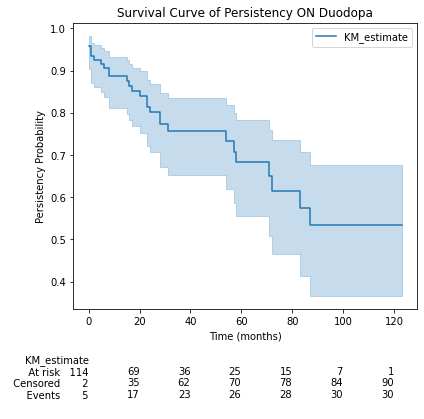

In [19]:
from lifelines.utils import median_survival_times



# Create Kaplan-Meier estimator
kmf = KaplanMeierFitter()

kmf.fit(durations=df_survival['duration_followup_months'], 
        event_observed=df_survival['dropout_cause'])


median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)


# Plot the survival curve
plt.figure(figsize=(6, 6))
kmf.plot_survival_function()
plt.title('Survival Curve of Persistency ON Duodopa')
plt.xlabel('Time (months)')
plt.ylabel('Persistency Probability')
plt.grid(False)

# Add at-risk table
from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf)

plt.tight_layout()
plt.show()

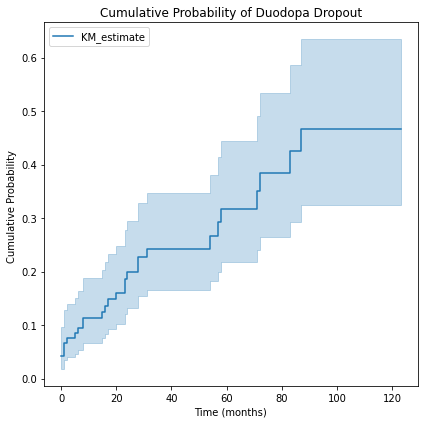

In [20]:

# Plot the survival curve
plt.figure(figsize=(6, 6))
kmf.plot_cumulative_density()
plt.title('Cumulative Probability of Duodopa Dropout')
plt.xlabel('Time (months)')
plt.ylabel('Cumulative Probability ')
plt.grid(False)

plt.tight_layout()
plt.show()

In [10]:
df_survival.columns

Index(['gender', 'age', 'age_disease_onset', 'apo_pompe_t0', 'dbs_t0',
       'disease_duration_duodopa_start', 'plus_5_medication_intakes',
       'efficacy_fluctuations_plus_2h', 'dyskinesias_plus_1h', 'updrs_IV_t0',
       'LEDD_total_t0', 'l_dopa_challenge_test_t0', 'mms_t0', 'moca_t0',
       'weight_t0', 'duration_followup_months', 'dropout_cause'],
      dtype='object')

In [25]:

# Your variable lists
categorical_vars = [
    'gender', 'apo_pompe_t0', 'dbs_t0',
    'plus_5_medication_intakes',
    'efficacy_fluctuations_plus_2h', 'dyskinesias_plus_1h'
]

numeric_vars = [
    'age', 'age_disease_onset',
    'disease_duration_duodopa_start', 'updrs_IV_t0',
    'LEDD_total_t0', 'l_dopa_challenge_test_t0', 'mms_t0', 'moca_t0',
    'weight_t0'
]

time_col = 'duration_followup_months'
event_col = 'dropout_cause'

results = []

# Standardize numeric variables
scaler = StandardScaler()
df_survival[numeric_vars] = scaler.fit_transform(df_survival[numeric_vars])

for var in categorical_vars + numeric_vars:
    # Select only time, event, and the variable of interest
    df_subset = df_survival[[time_col, event_col, var]].copy()
    
    # Drop rows with missing time, event, or this variable
    df_subset = df_subset.dropna(subset=[time_col, event_col, var])
    
    
    # Convert categorical vars to category dtype
    if var in categorical_vars:
        df_subset[var] = df_subset[var].astype('category')
    
    cph = CoxPHFitter()
    try:
        cph.fit(df_subset, duration_col=time_col, event_col=event_col)
        summary = cph.summary
        summary['variable'] = var
        results.append(summary)
    except Exception as e:
        print(f"Error fitting Cox model for {var}: {e}")

# Combine results into one DataFrame
results_df = pd.concat(results)

# Show key results (coefficients, p-values, hazard ratios)
print(results_df)


                                coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                   
gender                          0.55       1.73      0.37           -0.17   
apo_pompe_t0                   -0.59       0.55      0.38           -1.34   
dbs_t0                          0.11       1.12      0.44           -0.75   
plus_5_medication_intakes       0.11       1.12      0.49           -0.85   
efficacy_fluctuations_plus_2h   0.20       1.22      0.73           -1.24   
dyskinesias_plus_1h             0.62       1.86      0.38           -0.13   
age                            -0.07       0.94      0.20           -0.46   
age_disease_onset              -0.21       0.81      0.18           -0.56   
disease_duration_duodopa_start  0.19       1.21      0.18           -0.15   
updrs_IV_t0                     0.10       1.10      0.19           -0.27   
LEDD_total_t0                  -0.25       0.78      0.20           -0.64   

In [26]:
results_df.to_csv('../output/results_df.csv')

C:\Users\paulo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\zepid\graphics\graphics.py:156: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if not np.isnan(self.df['OR2'][i]):
C:\Users\paulo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\zepid\graphics\graphics.py:157: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ((isinstance(self.df['OR'][i], float)) & (isinstance(self.df['LCL'][i], float)) &
C:\Users\paulo\AppData\Local\Packages\PythonSoftwareFoundation.Python

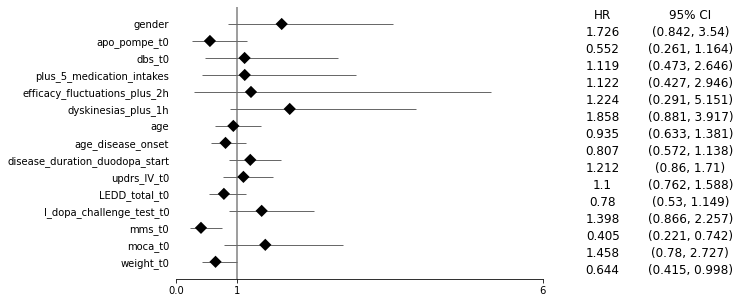

In [30]:
import zepid
from zepid.graphics import EffectMeasurePlot


p = EffectMeasurePlot(label=results_df['variable'], 
                      effect_measure=results_df['exp(coef)'], 
                      lcl=results_df['exp(coef) lower 95%'], 
                      ucl=results_df['exp(coef) upper 95%'])
p.labels(effectmeasure='HR')
p.colors(pointshape="D")
ax=p.plot(figsize=(10,5), t_adjuster=0.0, max_value=6, min_value=0.0 )
#ax.set_xlabel("No effect                               Favours effect       ", fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(False)


In [8]:

def plot_km_by_group(df, group_col, duration_col='duration_followup_months', event_col='dropout_cause'):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(6, 6))

    for group in df[group_col].dropna().unique():
        mask = df[group_col] == group
        kmf.fit(df[mask][duration_col], df[mask][event_col], label=f"{group_col}={group}")
        kmf.plot_survival_function()

    plt.title(f'Survival by {group_col}')
    plt.xlabel('Time (months)')
    plt.ylabel('Survival Probability')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

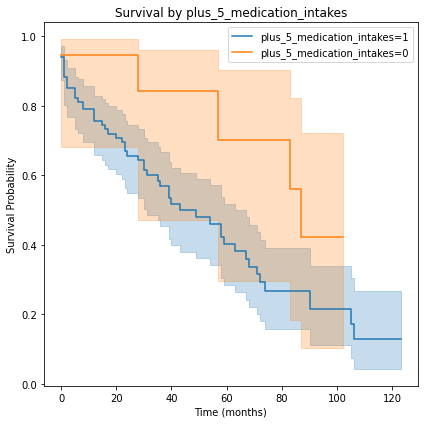

In [16]:
df_survival['mms_group'] = pd.cut(df_survival['mms_t0'], bins=[0, 5, 10, 15, 20, 25, 30], 
                                  labels=['<5', '<10', '<15', '<20', '<25', '<30'])

plot_km_by_group(df_survival, 'plus_5_medication_intakes')

In [18]:
df_survival_short = df_survival[['gender', 'age_disease_onset', 'apo_pompe_t0', 'dbs_t0',
       'disease_duration_duodopa_start', 'plus_5_medication_intakes',
       'efficacy_fluctuations_plus_2h', 'dyskinesias_plus_1h', 'updrs_IV_t0',
       'LEDD_total_t0', 'l_dopa_challenge_test_t0', 'mms_t0', 'moca_t0',
       'weight_t0', 'duration_followup_months', 'dropout_cause', ]]